In [1]:
import random
import numpy as np
import matplotlib
import time
from numba import jit
import multiprocessing as mp
from matplotlib import pyplot as plt

# Demand function

In [2]:
@jit(nopython=True)
def demand(p1, p2):
    if p1 < p2:
        return (1 - p1)
    elif p1 > p2:
        return 0
    else:
        return (0.5 * (1 - p1))

# Profit function

In [3]:
@jit(nopython=True)
def profit(p1, p2):
    return (p1 * demand(p1, p2))

In [4]:
P = np.array([0, 1/6, 2/6, 3/6, 4/6, 5/6, 1]) # price array

# Hjælpefunktion..

In [5]:
@jit(nopython=True)
def epsilon_greedy(Qtable, epsilon, uniform, state: int, price_grid: np.ndarray) -> int: 
    N = len(price_grid)
    assert Qtable.shape[0] == N, "Qtable must have the same number of rows as there are prices in the grid"
    assert Qtable.shape[1] == N, "Qtable must have the same number of columns as there are prices in the grid"
    assert state < N, "state must be a valid index in the price grid"
    assert state >= 0, "state must be a valid index in the price grid"

    # Draw action 
    if uniform < epsilon:
        price_index = np.random.choice(N)
    else:
        price_index = np.argmax(Qtable[:, state])
    return price_index

# Q-learning and simulation function

In [6]:
@jit(nopython=True)
def Qfunction(price_grid, period, delta, alpha, theta):
    # Initialize prices and Q-tables
    price_index_i = np.random.choice(len(price_grid)) 
    price_index_j = np.random.choice(len(price_grid)) 

    state = np.random.choice(len(price_grid))

    Qtable_1 = np.zeros((len(price_grid), len(price_grid)))
    Qtable_2 = np.zeros((len(price_grid), len(price_grid)))

    price_lists = np.zeros((int(period+1), int(2)))
    profit_lists = np.zeros((int(period+1), int(2)))

    total_profit = np.zeros(period)

    epsilons = (1 - theta)**np.arange(period + 1)
    uniforms = np.random.uniform(0, 1, (period + 1, 2))

    for t in range(period + 1):
        epsilon = (1 - theta)**t

        # figure out who's turn it is
        if t % 2 == 0:
            # player 2 is the responder
            # set up pointers to the state and the Q table 
            state = price_index_i # the most recent draw of player 1's price
            Qtable_i = Qtable_2 
            Qtable_j = Qtable_1
            price_list_index = 1
            profit_list_index = 1
        else:
            # player 1 is the responder
            state = price_index_j
            Qtable_i = Qtable_1
            Qtable_j = Qtable_2
            price_list_index = 0
            profit_list_index = 0

        # draw i's action 
        # (actually, player i's action is already simulated by player j in the previous period)
        price_index_i = epsilon_greedy(Qtable_i, epsilon, uniforms[t, 0], state=state, price_grid=price_grid)

        # current period 
        decision = price_grid[price_index_i]
        state_i_responds_to = price_grid[state]
        profit_i_current_period = profit(decision, state_i_responds_to)

        # next period 
        state_next_period = price_index_i # next_period's state is today's price
        price_index_j = epsilon_greedy(Qtable_j, epsilon, uniforms[t, 1], state=state_next_period, price_grid=price_grid)

        price_j_next_period = price_grid[price_index_j]
        price_i_next_period = price_grid[price_index_i] # unchanged price, it's not i's turn 
        profit_i_next_period = profit(price_i_next_period, price_j_next_period)

        max_Q = np.max(Qtable_i[:, price_index_j])
        continuation_value = max_Q 

        new_Q = profit_i_current_period + delta * profit_i_next_period + delta**2 * continuation_value

        # Update
        prev_estimate = Qtable_i[price_index_i, price_index_j]
        Qtable_i[price_index_i, price_index_j] = (1 - alpha) * prev_estimate + alpha * new_Q

        # Update pricelist
        price_lists[t, price_list_index] = decision

        # Profit
        profit_lists[t, profit_list_index] = profit_i_current_period
        total_profit[t-1] = profit_i_current_period

    return price_lists, profit_lists, total_profit


@jit(nopython=True)
def Simulations(sim, price, period, delta, alpha, theta):
    total_profit_sim = np.zeros((sim, period))

    for i in range(sim):
        _, _, total_profit_sim[i, :] = Qfunction(price, period, delta, alpha, theta)

    return total_profit_sim

# Optimality

In [28]:
def delta_prof(avg_array, sim):
    #together_array = np.mean(avg_array, axis=0)
    total = np.zeros(sim)
    delta_1 = np.zeros(sim)
    for i in range(sim):
        total[i] = (avg_array[i, -1] + avg_array[i, -2])/2 # gennemsnit af profit i de sidste to perioder
        delta_1[i] = ((total[i]) / (0.125))
    return delta_1

# Time calculation for 1000 simulations

In [8]:
start_time  = time.time()

np.random.seed(387)
total_profit_plot = Simulations(1000, P, 500000, 0.95, 0.3, 0.0000276306)

end_time = time.time()

elapsed_time = end_time - start_time

print("Time taken to run 1000 simulations:", elapsed_time, "seconds")

Time taken to run 1000 simulations: 39.315637826919556 seconds


In [29]:
#dividing delta into intervals
def delta_div(delta_arr):
    new_delt = np.zeros(5)
    for i in range(len(delta_arr)):
        if delta_arr[i] <=1 and delta_arr[i] > 0.9: 
            new_delt[4]+=1
        elif delta_arr[i] <=0.9 and delta_arr[i] > 0.8:
            new_delt[3]+=1
        elif delta_arr[i] <=0.8 and delta_arr[i] > 0.7:
            new_delt[2]+=1
        elif delta_arr[i] <= 0.7 and delta_arr[i] > 0.6:
            new_delt[1]+=1
        else:
            new_delt[0] +=1
    return new_delt

In [30]:
delta_1 = delta_prof(total_profit_plot, 1000)

delta_2 = delta_div(delta_1)



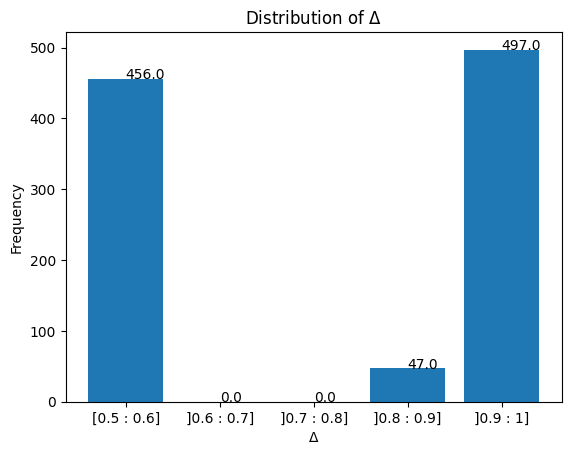

In [31]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i])

langs = ['[0.5 : 0.6]', ']0.6 : 0.7]', ']0.7 : 0.8]', ']0.8 : 0.9]', ']0.9 : 1]']

y_pos = np.arange(len(langs))

plt.title("Distribution of $\Delta$")
# Create bars
plt.bar(y_pos, delta_2)

addlabels(langs, delta_2 )
# Create names on the x-axis
plt.xticks(y_pos, langs)
plt.xlabel("$\Delta$")
plt.ylabel("Frequency")
#make label
label = [delta_2]
# Show graphic
plt.show()

In [12]:
samlet_prof = total_profit_plot.mean(0)
window_size = 1000
  
i = 0
# Initialize an empty list to store moving averages
moving_averages = []
# Loop through the array t o
#consider every window of size 1000
while i < len(samlet_prof) - window_size + 1:
  
    # Calculate the average of current window
    window_average = np.sum(samlet_prof[i:i+window_size]) / window_size
      
    # Store the average of current
    # window in moving average list
    moving_averages.append(window_average)
      
    # Shift window to right by one position
    i += 1

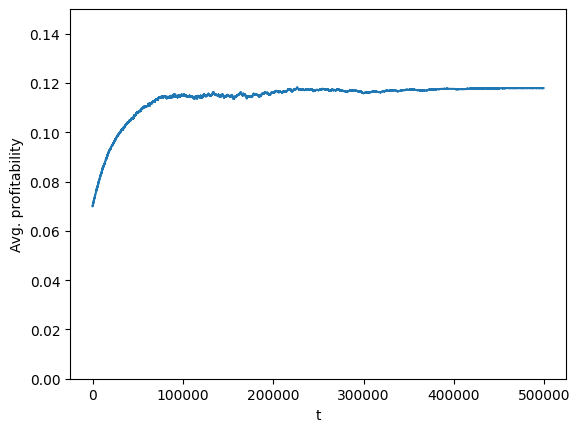

In [13]:
plt.plot(moving_averages, label="Average profitability")
plt.xlabel('t')
plt.ylabel('Avg. profitability')
plt.ylim(0.00, 0.15)
plt.show()